In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

## Defining Alice and Bob Requirements

Alice has to communicate a qubit Q and has an e-bit shared with Bob. It is assumed that Alice and Bob can only send classical information. Alice and Bob share an e-bit.

### Assumptions :
1. State of Q is NOT known to Alice and Bob
2. Correlation between Q and other systems must be preserved by transmission
3. According to the "No cloning theorem", if Bob receives the transmission then Alice must no longer have the qubit Q in its original state.

In [19]:
qubit = QuantumRegister(1, "Q")         # Q
ebit0 = QuantumRegister(1, "A")         # A
ebit1 = QuantumRegister(1, "B")         # B
a = ClassicalRegister(1, "a")           # a
b = ClassicalRegister(1, "b")           # b

## Defining the Protocol

1. Alice performs controlled-NOT operation where Q is the control and A is the target.
2. Alice performs a Hadamard operation on Q.
3. Alice measures A and Q, gets classical bits a and b respectively then sends a and b to Bob.
4. Bob performs X operation (NOT gate) if a = 1, and if b = 1 then Bob performs operation Z (phase flip operation) on B.

Therefore, 
    if ab = 00 then `1`
    if ab = 01 then operation Z
    if ab = 10 then operation X
    if ab = 11 then operation ZX

In [20]:
protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)       # Controlled NOT where control is Q (qubit) and target is A (ebit0)
protocol.h(qubit)               # Hadamard gate on Q
protocol.barrier()

# Now measure ebit0, store in a and measure qubit, store in b and send to B
protocol.measure(qubit, b)
protocol.measure(ebit0, a)
protocol.barrier()

# Bob's actions based on classical bits
with protocol.if_test((a, 1)):
    protocol.x(ebit1)           # if a is 1 then operation X on ebit1
with protocol.if_test((b, 1)):
    protocol.z(ebit1)           # if b is 1 then operation Z on ebit1
    
print(protocol.draw())

                ░      ┌───┐ ░ ┌─┐    ░                                     »
  Q: ───────────░───■──┤ H ├─░─┤M├────░─────────────────────────────────────»
     ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░                                     »
  A: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░─────────────────────────────────────»
     └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░ ┌────── ┌───┐ ───────┐ ┌────── ┌───┐»
  B: ─────┤ X ├─░────────────░──╫──╫──░─┤ If-0  ┤ X ├  End-0 ├─┤ If-0  ┤ Z ├»
          └───┘ ░            ░  ║  ║  ░ └──╥─── └───┘ ───────┘ └──╥─── └───┘»
                                ║  ║    ┌──╨──┐                   ║         »
a: 1/═══════════════════════════╬══╩════╡ 0x1 ╞═══════════════════╬═════════»
                                ║  0    └─────┘                ┌──╨──┐      »
b: 1/═══════════════════════════╩══════════════════════════════╡ 0x1 ╞══════»
                                0                              └─────┘      »
«               
«  Q: ──────────
«               
«  A: ───────

In [21]:
# Randomly generated single qubit to check if protocol is successful
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)
print(random_gate.to_matrix())

[[-0.97036782+0.j         -0.09747802-0.22109801j]
 [-0.14169986+0.19572288j  0.94876651+0.20360699j]]


In [22]:
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

test.append(random_gate, qubit)
test.barrier()

test = test.compose(protocol)       # Including the protocol as defined before
test.barrier()

# Apply random unitary to B and measure
test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

print(test.draw())

          ┌─────────────────────────┐ ░            ░      ┌───┐ ░ ┌─┐    ░ »
       Q: ┤ U(5.7951,2.1974,1.1556) ├─░────────────░───■──┤ H ├─░─┤M├────░─»
          └─────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░ »
       A: ────────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░─»
                                      ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░ »
       B: ────────────────────────────░──────┤ X ├─░────────────░──╫──╫──░─»
                                      ░      └───┘ ░            ░  ║  ║  ░ »
     a: 1/═════════════════════════════════════════════════════════╬══╩════»
                                                                   ║  0    »
     b: 1/═════════════════════════════════════════════════════════╩═══════»
                                                                   0       »
Result: 1/═════════════════════════════════════════════════════════════════»
                                                                           »

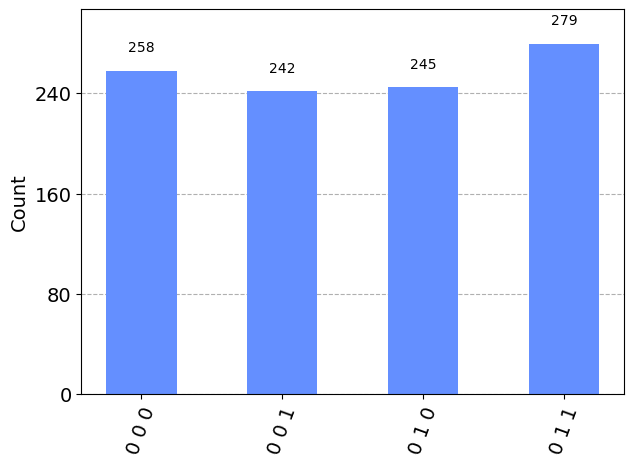

In [23]:
# AER simulation
result = AerSimulator().run(test).result()
statistics = result.get_counts()
plot_histogram(statistics)

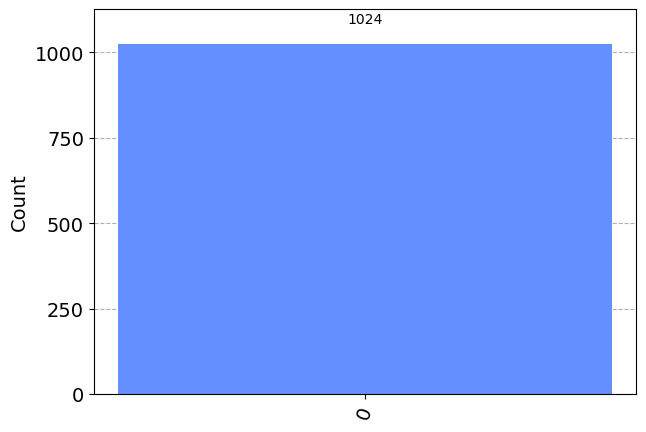

In [24]:
filtered_statistics = marginal_distribution(statistics, [2])
plot_histogram(filtered_statistics)